# AutoFormalism with Llama 3 Results

We attempt to reproduce the in-context results of the paper [Autoformalism with LLMS](http://arxiv.org/abs/2205.12615).  The idea is to prompt an LLM to translate mathematical statements in to a full formal logical language. The paper chooses to translate to the proof assistant language [Isabelle](https://isabelle.in.tum.de/).  The LLM's used in the paper were [PALM](https://ai.google/discover/palm2/) and [Codex](https://openai.com/blog/openai-codex) but in this notebook we use [LLama3-70b](https://llama.meta.com/llama3/). 

In [1]:
import json
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction


from autoformalism_with_llms.dataset import MiniF2FMATH
from autoformalism_with_llms import prompt


In [2]:
MODEL = "llama3-70b-instruct"

----
## Load Data
We previously excuted `run_experiment.py` which uses [replicate](https://replicate.com/) and requires an API token in the environment.  The LLM responses are saved to disk, along with some metadata, so we now load this into memory.

In [3]:
def load_results(log_dir: str | Path)->list:
    """Create list of results.

    Args:
        log_dir (str | Path): The the results are saved into.

    Returns:
        (list): A list of dictionaries containing the chat completion and 
            the Math question.
    """
    files = Path(log_dir).rglob("*.json")
    results = []
    dataset = None 
    for fname in files:
        with open(fname, 'r') as f:
            data = json.load(f)
        metadata = data.pop('metadata')
        subject, qid = metadata['subject'], metadata['question_number']
        if dataset is None:
            dataset = MiniF2FMATH().get_subject(subject)
        completion = "".join(data["response"])
        question = dataset.get_question(qid)
        results.append({"completion":completion, "question":question, 'metadata':metadata})
    return results



def remove_spaces_around_operators(math:str)->str:
    """Removes spaces around +,-,*,/,= in an Isabelle string.

    We don't want our translation results to be thrown off by the arbitrary
    choice of whether to put spaces around operators.  Even in some target strings
    there are a mixed use of spaces.  This function removes all spaces around the 
    operator.  Note that also reduces BLEU scores since there are less tokens for 
    matching.

    Args:
        math (str): An Isabelle formal statement.

    Returns:
        The statement where the spaces around operators is removed.
    """
    return re.sub(r" *([\*\+\-\/=]) *", r"\1", math)


def remove_hypothesis_name(math:str)->str:
    """Removes named hypothesis like (e.g. `h0:`, `h1:`)

    The hypothesis in Isabelle can be named so they can be explicitly 
    referred to.  We want to check BLEU scores after normalizing the statements
    by removing these arbitrary names to get a sense of how well the model 
    translated the core of the statement without having the scores thrown off
    by these hypothesis names.
    """
    x= re.sub(r"h[0-9]\s*:", "", math, re.MULTILINE)
    return re.sub(r" +", " ", x)  # remove extra spaces we may have created.
    

# Some sanity checks for our preprocessing functions
def test_remove_spaces_around():
    """Simple test that the regex is doing what we think"""
    ops = list("+*-/=")
    for op in ops:
        math = f"space 3 {op} x around"
        actual = remove_spaces_around_operators(math)
        expected = f"space 3{op}x around"
        assert actual == expected, f"OP:{op} | {actual}!={expected}"

def remove_hypothesis_name_removes_name():
    math = "theorem \nmy hyp h0 : is"
    actual = remove_hypothesis_name(math)
    expected = "theorem \nmy hyp is"
    assert actual==expected, f"{actual}!={expected}"

Sanity check our preprocessing functions.

In [4]:
test_remove_spaces_around()
remove_hypothesis_name_removes_name()
print("All tests passed")

All tests passed


Now onto calculating BLEU scores, which roughly measure how well our LLM "translated" from natural language to Isabelle.

In [5]:
def calculate_bleu(results:list[dict], normalize:bool=True, smoothing_method:str="method4"):
    """Calculate BLEU scores over the entire corpus of results.

    Args:
        results (list): A list of dictionaries containing the chat completion and 
            the Math question.
        normalize (bool): Whether to normalize the strings before calculating the BLEU score.
        smoothing_method (str): The smoothing method to use for the BLEU score. 
            Default is "method4"
    """
    smooth = getattr(SmoothingFunction(), smoothing_method)
    
    references = []
    hypothesis = []
    for d in results:
        x = d['completion']
        y = prompt.get_formal_language_message(d['question'])['content']
        if normalize:
            x = _normalize(x)
            y = _normalize(y)
        x = x.split()
        y = y.split()
        references.append([x])
        hypothesis.append(y)
        
    
    bleu = corpus_bleu(references, hypothesis, smoothing_function=smooth)
    return bleu


def calculate_sentence_bleu(results:list, normalize:bool=True, smoothing_method:str="method4"):
    """Calculates the blue score for each sentence in the results

    This returns a list of scores, a list of pairs of (y_true, y_pred), and list of question ids.
    The data returned by this function can be used to figure out how many sentences have perfect 
    translations and to identify them directly.

    Args:
        results (list): A list of dictionaries containing the chat completion and 
            the Math question.
        normalize (bool): Whether to normalize the strings before calculating the BLEU score.
        smoothing_method (str): The smoothing method to use for the BLEU score. 
            Default is "method4"
    """
    smooth = getattr(SmoothingFunction(), smoothing_method)
    scores = []
    pairs = []
    ids = []

    for d in results:
        x = d['completion']
        y = prompt.get_formal_language_message(d['question'])['content']
        if normalize:
            x = _normalize(x)
            y = _normalize(y)
        x = x.split()
        y = y.split()
        pairs.append((x,y))
        ids.append(d['question'].question_number)
        scores.append(sentence_bleu([x],y, smoothing_function=smooth))
    
    return scores, pairs, ids

def _normalize(x): 
    x = remove_spaces_around_operators(x)
    x = remove_hypothesis_name(x)
    return x

Start by loading the algebra and number theory datasets, and the results for each GPT version

In [6]:
algebra_data = MiniF2FMATH().get_subject("algebra")
numtheory_data = MiniF2FMATH().get_subject("numbertheory")



alg = load_results(f"artifacts/{MODEL}/algebra")
num = load_results(f"artifacts/{MODEL}/numbertheory")

Now calculate the bleu scores for each GPT model on each dataset.

In [7]:
alg_bleu = calculate_bleu(alg, normalize=False)
num_bleu = calculate_bleu(num, normalize=False)

In [8]:
def plot_bleu(scores, labels=["Algebra", "Number Theory"], ax=None):
    """Simple bar plot for blue scores."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    assert len(scores) == len(labels), "Need a label for each set of scores"
    sns.barplot(x=labels, y=scores, ax=ax)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Average BLEU Score")
    ax.set_ylabel("BLEU Score")
    return fig, ax

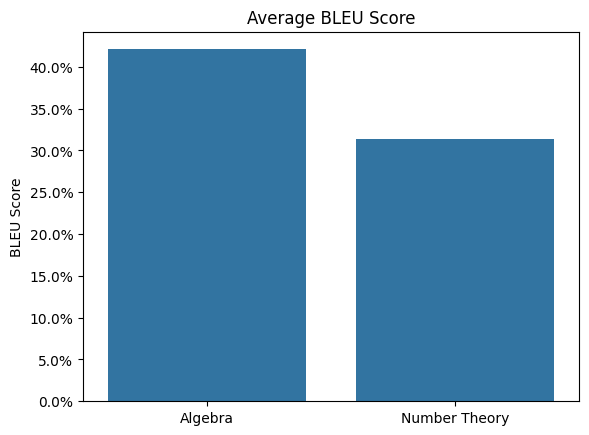

In [9]:
_ = plot_bleu([alg_bleu, num_bleu])

This figure shows the BLEU scores for LLama-3-70b from translating informal math to formal math on the algebra and number theory datasets. This scores are much lower than the best score reported in the paper, which was 57% for Codex on the algebra dataset. 

### Repeat with normalization

In [10]:
alg_bleu_norm = calculate_bleu(alg, normalize=True)
num_bleu_norm = calculate_bleu(num, normalize=True)

Text(0.5, 1.0, 'Average BLEU Score\nNormalized Statement')

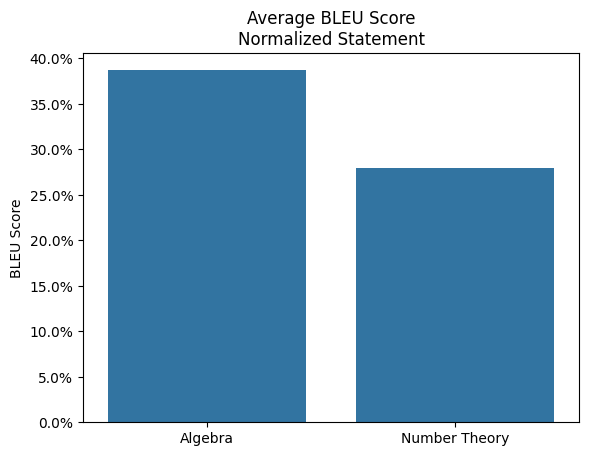

In [11]:
fig, ax = plot_bleu([alg_bleu_norm, num_bleu_norm])
ax.set_title("Average BLEU Score\nNormalized Statement")

The normalized statements receive a slightly lower score.  Even though normalization helps correct things like making sure `x + 1` and `x+1` are equivalent, it also shortens the number of tokens in each sentence which biases the scores lower (each mistake is a larger fraction of the total). 

----
## Checking the Prompt
The results in the previous section are worse than the results reported in the original paper, where the Codex model achieved a BLEU score of ~57%.  Let's sanity check out prompt.

In [12]:
from run_experiment import make_fewshot_prompt, FEWSHOTIDS

for d in make_fewshot_prompt(algebra_data, FEWSHOTIDS.algebra):
    print(f"{d['role']}: {d['content']}\n")

system: Translate the following natural language math problem to the Isabelle theorem proving language.  Do not provide a proof of the statement. Use dilligence when translating the problem and make certain you capture all the necessary assumptions as hypotheses.

user: Simplify $\left( \frac{4}{x} \right)^{-1} \left( \frac{3x^3}{x} \right)^2 \left( \frac{1}{2x} \right)^{-3}$. The final answer is $18x^8$.

assistant: theorem
  fixes x :: real
  assumes h0 : "x \<noteq> 0"
  shows "1/(4/x) * ((3*x^3)/x)^2 * (1/(1 / (2 * x)))^3 = 18 * x^8"

user: For integers $n$, let \[f(n) = \left\{
\begin{array}{cl}
n^2 & \text{ if }n\text{ is odd}, \\
n^2 - 4n - 1 & \text{ if }n\text{ is even}.
\end{array}
\right.\]Find $f(f(f(f(f(4)))))$. The final answer is $1$.

assistant: theorem
  fixes f :: "int \<Rightarrow> int"
  assumes "\<forall>n. odd n \<longrightarrow> f n = n^2"
    and "\<forall> n. even n \<longrightarrow> f n = n^2 - 4*n -1" 
  shows "f 4 = -1"

user: The volume of a cone is given b

Note that the prompt we are using does few-shot learning in the form of "user/assistant" pairs where the users inputs a natural langauge math statement and the LLM translates it to Isabella.  The prompt used in the paper is a single prompt and one of the main differences is the repeated reminder (in each example) of the task to translate to Isabella.  However, this doesn't seem like a huge limitation since the LLM is clearly outputting Isabella code in its responses so its faithfully following the task.

By inspection we appear to be using the exact same few shot examples in the exact same order.

----
## Inspect examples

We now inspect some examples to see what types of translations the model tends to get right and wrong.

In [14]:
def get_good_examples(blue_scores, threshold=0.7):
    scores, pairs, ids = blue_scores
    return [pair for (score, pair) in zip(scores,pairs) if score > threshold], [id for (score, id) in zip(scores, ids) if score > threshold]

def get_bad_examples(blue_scores, threshold=0.2):
    scores, pairs, ids = blue_scores
    return [pair for (score, pair) in zip(scores,pairs) if score < threshold], [id for (score, id) in zip(scores, ids) if score < threshold]

alg_sentence_bleu = calculate_sentence_bleu(alg, normalize=True)
num_sentence_bleu = calculate_sentence_bleu(num, normalize=True)

alg_good, alg_good_id = get_good_examples(alg_sentence_bleu)
alg_bad, alg_bad_id = get_bad_examples(alg_sentence_bleu)
num_good, num_good_id = get_good_examples(num_sentence_bleu)
num_bad, num_bad_id = get_bad_examples(num_sentence_bleu)

In [18]:
print(f"Perfect Algebra Translations: {len([x for x in alg_sentence_bleu[0] if x==1.0])} out of {len(alg_sentence_bleu[0])}")
print(f"Perfect Number Theory Translations: {len([x for x in num_sentence_bleu[0] if x==1.0])} out of {len(num_sentence_bleu[0])}")

Perfect Algebra Translations: 14 out of 130
Perfect Number Theory Translations: 13 out of 110


The number of perfect translations are lower than reported in the paper.  Let's take a look at some examples to make sure our metric is relatively sane.

In [19]:
examples = [0,1,2,3,4,5]
print("Algebra Examples\n----------------")
for i in examples:
    print(f"Good Example {i}")
    question = algebra_data.get_question(alg_good_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(alg_good[i][0])}\n{' '.join(alg_good[i][1])}\n")
    print(f"Bad Example {i}")
    question = algebra_data.get_question(alg_bad_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(alg_bad[i][0])}\n{' '.join(alg_bad[i][1])}\n")

Algebra Examples
----------------
Good Example 0
Assuming $x\ne0$, simplify $\frac{12}{x \cdot x} \cdot \frac{x^4}{14x}\cdot \frac{35}{3x}$. The final answer is $10$.
theorem fixes x :: real assumes "x \<noteq> 0" shows "(12/(x*x))*((x^4)/(14*x))*(35/(3*x))=10"
theorem fixes x :: real assumes "x \<noteq> 0" shows "12/(x*x)*(x^4/(14*x))*(35/(3*x))=10"

Bad Example 0
A line $\ell$ passes through the points $B(7,-1)$ and $C(-1,7)$.  The equation of this line can be written in the form $y=mx+b$; compute $m+b$. The final answer is $5$.
theorem fixes m b :: real assumes "\<forall> x. (x, m*x+b) \<in> {(7,-1), (-1, 7)}" shows "m+b=5"
theorem fixes m b ::real assumes "m*7+b=-1" and "m*(-1)+b=7" shows "m+b=5"

Good Example 1
Three plus the reciprocal of a number equals 7 divided by that number.  What is the number? The final answer is $2$.
theorem fixes x :: real assumes "x \<noteq> 0" and "3+1/x=7/x" shows "x=2"
theorem fixes x :: real assumes "x \<noteq> 0" and "3+1/x=7/x" shows "x=2"

Bad Ex

In [20]:
examples = [0,1,2,3,4]
print("Number Theory Examples\n----------------------")
for i in examples:
    print(f"Good Example {i}")
    question = numtheory_data.get_question(num_good_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(num_good[i][0])}\n{' '.join(num_good[i][1])}\n")
    print(f"Bad Example {i}")
    question = numtheory_data.get_question(num_bad_id[i])
    print(prompt.get_natural_language_message(question)['content'])
    print(f"{' '.join(num_bad[i][0])}\n{' '.join(num_bad[i][1])}\n")

Number Theory Examples
----------------------
Good Example 0
Find the remainder when $91145 + 91146 + 91147 + 91148$ is divided by 4. The final answer is $2$.
theorem "(91145+91146+91147+91148) mod 4=(2::nat)" by eval end
theorem "(91145+91146+91147+91148) mod 4=(2::nat)" by eval end

Bad Example 0
What positive two-digit integer is exactly twice the sum of its digits? The final answer is $18$.
theorem fixes x y :: nat assumes "10\<le>x*10+y \<and> x*10+y\<le>99" and "2*(x+y)=x*10+y" shows "x*10+y=18"
theorem fixes a b :: nat assumes "1\<le>a \<and> a \<le>9 \<and> b \<le>9" and "10*a+b=2*(a+b)" shows "10*a+b=18"

Good Example 1
Solve the congruence $2n \equiv 15 \pmod{47}$, as a residue modulo 47.  (Give an answer between 0 and 46.) The final answer is $31$.
theorem fixes n :: nat assumes "(2*n) mod 47=15" shows "n=31"
theorem fixes n :: nat assumes "(2*n) mod 47=15" shows "n mod 47=31"

Bad Example 1
Let $n = 3^{17} + 3^{10}$. It is known that $11$ divides into $n+1$. If $n$ can be w

## Conclusion
We set out to reproduce the in-context learning results for the [Autoformalism with Large Language Models](http://arxiv.org/abs/2205.12615).  The original paper uses the Palm family of models and OpenAI's Codex model.  They show the best translation results are using the Codex model, but unfortunately that model has been discontinued.  In place of Codex, in this notebook we used Llama3-70b and found the translation results to be inferior to those found in the original paper. 

----
## Appendix

The BLEU score can be measured with different smoothing methods.  The authors of the original paper do not mention the smoothing method they used, if any.  Here we try all the methods available to see if this can account for the difference in performance between our results and the original paper.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Average BLEU Score'}, ylabel='BLEU Score'>)

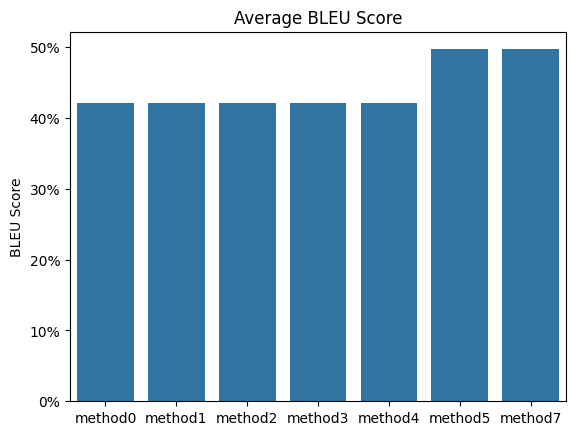

In [25]:
scores = []
labels = []
for i in range(8):
    if i==6:
        continue
    try:
        _alg_bleu = calculate_bleu(alg, normalize=False, smoothing_method=f"method{i}") 
        scores.append(_alg_bleu)
        labels.append(f"method{i}")
    except:
        pass


plot_bleu(scores, labels)

Methods 5 & 7 result in slightly higher scores but still below the scores reported in the original paper.